In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from matlab_functions import matern_covariance, matern_variogram, cov_ls_est, cov_ml_est, emp_variogram, parula_map
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import cholesky
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(3600, 3600)


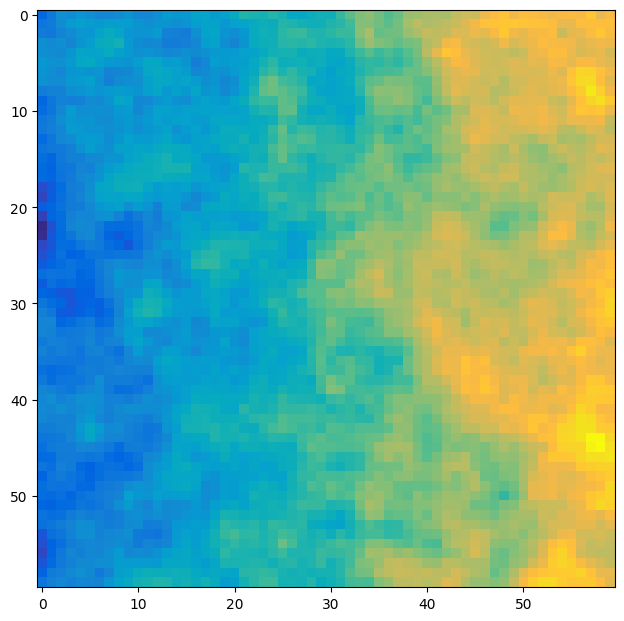

In [25]:

spread = np.linspace(0, 100, 60)
X, Y = np.meshgrid(spread, spread)
loc = np.column_stack((X.flatten(), Y.flatten()))
D = squareform(pdist(loc))
print(D.shape)
nu = 1
rho = 10
kappa = np.sqrt(8*nu)/rho
sigma = 1
r = matern_covariance(D, sigma, kappa, nu)
# scipys cholesky function returns lower triangular matrix by default,
# but matlab's chol function returns upper triangular matrix which is the
# same behavior as matlabs chol function.
R = cholesky(r, lower=False)
z = np.random.randn(R.shape[0])[:, np.newaxis]
n = X.shape[0]
beta1 = 1
beta2 = 0.1
mu = beta1 + beta2*X.flatten()
se = 0.05
gas = mu[:, np.newaxis] + R.T @ z
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['figure.dpi'] = 100
plt.imshow(gas.reshape(X.shape), cmap=parula_map)


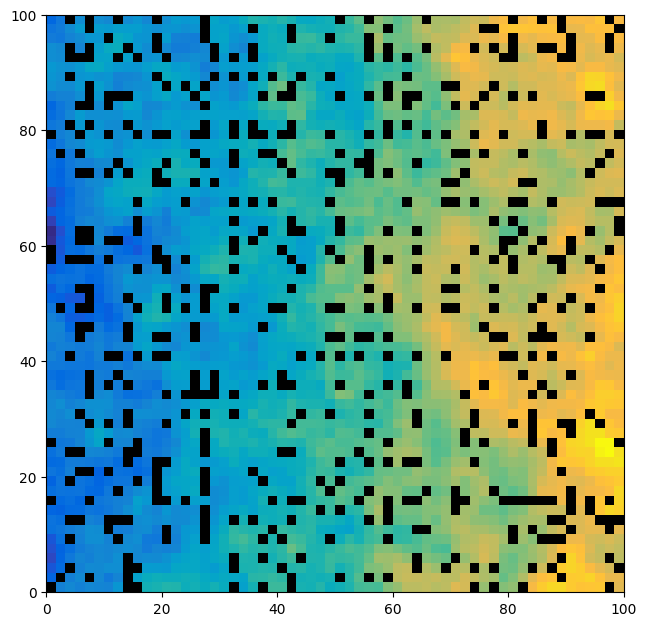

In [26]:

n_obs = 600 #Number of observations
ind = np.random.permutation(n*n) #Permute the indices of the pixels
ind_o = ind[0:n_obs] #Choose the first n_obs indices of the permuted indices. Those are the pixel indices that are observed
loc_o = loc[ind_o,:] #The locations of the observed pixels
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['figure.dpi'] = 100
plt.imshow(gas.reshape(X.shape), extent=(loc[:, 1].min(), loc[:, 1].max(), loc[:, 0].min(), loc[:, 0].max()), cmap=parula_map)

#plt.scatter(loc_o[:,0],loc_o[:,1], c="black", s=25, marker="s") #The observed pixels are the ones in the circles

gas_matrix = gas.reshape(X.shape)
# Create a masked array where the observed locations are True
mask = np.zeros_like(gas_matrix, dtype=bool)

for loc_i in loc_o:
    x_index = int((loc_i[1] - loc[:, 1].min()) / (loc[:, 1].max() - loc[:, 1].min()) * (X.shape[0]-1))
    y_index = int((loc_i[0] - loc[:, 0].min()) / (loc[:, 0].max() - loc[:, 0].min()) * (Y.shape[0]-1))
    mask[x_index, y_index] = True



# Create a custom colormap with two colors: the original color of the squares and black
colors = [(0, 0, 0)]
cmap = ListedColormap(colors)

# Create the imshow plot using the custom colormap
im = plt.imshow(gas_matrix, cmap=cmap, extent=(loc[:, 1].min(), loc[:, 1].max(), loc[:, 0].min(), loc[:, 0].max()))

# Set the color limits to [0, 1]
im.set_clim(0, 1)

# Color the specified locations black
im.set_data(np.ma.array(gas_matrix, mask=~mask))

# Show the plot
plt.show()

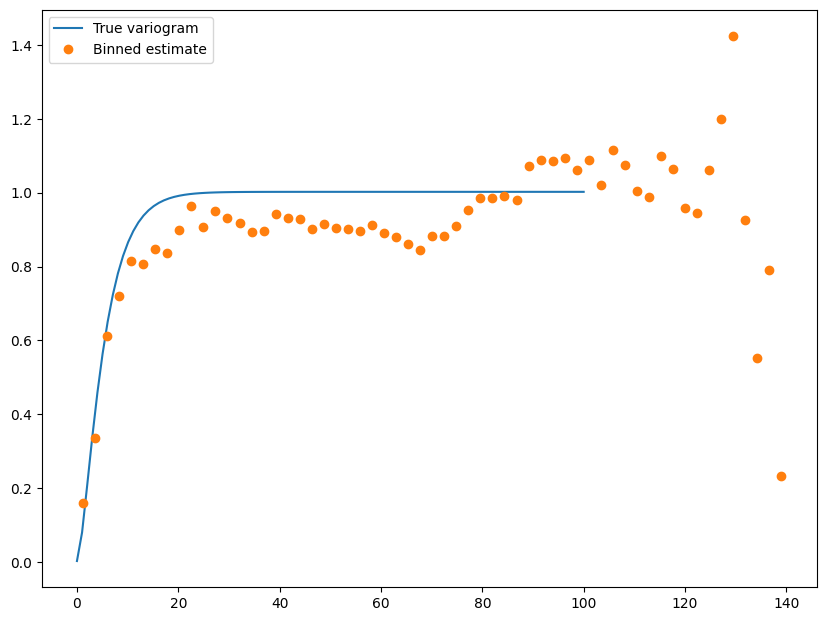

Optimization terminated successfully.
         Current function value: 772.968524
         Iterations: 464
         Function evaluations: 763
{'sigma': 0.9647162704242203, 'kappa': 0.17406718453578351, 'nu': 0.5649043271055676, 'sigma_e': 0.09617775521688046}


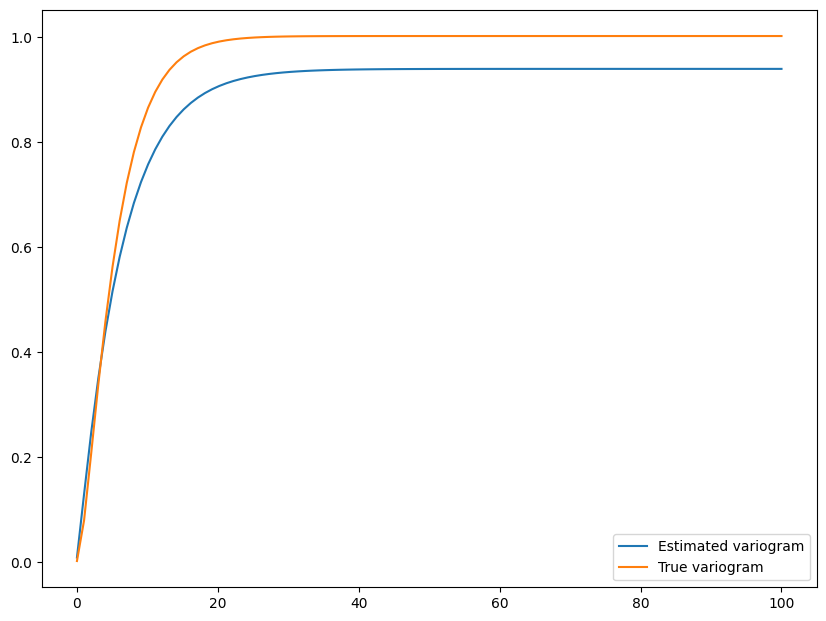

In [27]:
# Parameter estimation with GLS
Bo = np.hstack((np.ones((loc_o.shape[0], 1)), loc_o)) # Covariates ( I chose intercept + x + y coordinate here since you generally do not know how the data are generated).
# What is the coefficient estimate for y in this case?
# Since you know how the data are generated feel free to just use 1 + x as your covariates.
# Observed_data
Observed_values = gas[ind_o] + se*np.random.randn(n_obs,1) #NOTICE: The data are observed with some noise!!!
LSE = np.linalg.solve(Bo.T @ Bo, Bo.T @ Observed_values) # We use the formula for the LSE
e = Observed_values - Bo @ LSE # The residuals
# BIN THE RESIDUALS AND FIT VARIOGRAM
h = np.linspace(0,100,100)
emp_v = emp_variogram(loc_o, e, 60)
mat_v = matern_variogram(h,sigma,kappa,nu,se) #True vs binned estimate of the variogram
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['figure.dpi'] = 100
plt.plot(h,mat_v)
plt.plot(emp_v["h"], emp_v["variogram"],'o')
plt.legend(["True variogram", "Binned estimate"])
plt.show()
lse_estimates = cov_ls_est(e, 'matern' , emp_v) #Least-squares estimation of a Mat rn variogram to the binned estimate
print(lse_estimates)
#Estimated variogram
mat_v_new = matern_variogram(h,lse_estimates["sigma"],lse_estimates["kappa"],lse_estimates["nu"],lse_estimates["sigma_e"])
#True vs Estimated variogram
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['figure.dpi'] = 100
plt.plot(h,mat_v_new)
plt.plot(h,mat_v)
plt.legend(["Estimated variogram", "True variogram"])
plt.show()

In [12]:
# GLS estimates
# Covariance matrix
S = matern_covariance(D, lse_estimates["sigma"], lse_estimates["kappa"], lse_estimates["nu"])

matern covariance done
LSE done
first gls done it took:  0.057043721000809455
second gls done it took:  0.031766285001140204
[[ 0.47332539]
 [ 0.10937152]
 [-0.00092526]]
[[ 0.47332539]
 [ 0.10937152]
 [-0.00092526]]


In [23]:
# Now compare GLS vs LSE estimates
So = lse_estimates["sigma_e"]**2 * np.eye(loc_o.shape[0]) + S[ind_o, :][:, ind_o] #Sigma_O. NOTICE: We added a nugget term

gls = np.linalg.solve(Bo.T @ np.linalg.solve(So, Bo), Bo.T @ np.linalg.solve(So, Observed_values))
print("GLS estimate: ", gls)
print("LSE estimate: ", LSE)
print("True values: ", np.array([beta1, beta2, 0]).reshape(3,1))

GLS estimate:  [[ 0.48325073]
 [ 0.10924874]
 [-0.00103599]]
LSE estimate:  [[ 0.49467377]
 [ 0.11016575]
 [-0.00171505]]
True values:  [[1. ]
 [0.1]
 [0. ]]


In [24]:

# Image reconstruction with kriging
ind_p = ind[n_obs:] # indices and locations of the pixels to be predicted
loc_p = loc[ind_p, :]
Bp = np.hstack((np.ones((loc_p.shape[0], 1)), loc_p)) # covariates of points to be predicted B_p
mu2 = Bp @ gls # mu_p
mu1 = Bo @ gls # mu_0
Sp = S[ind_p, :][:, ind_p] # Sigma_p
Sop = S[ind_o, :][:, ind_p] # Sigma_op
# Now we have all the elements we need to reconstruct the image
krig = mu2 + Sop.T @ np.linalg.solve(So, e) # The kriging prediction
# NOTICE: I do not use inv() function to invert matrices (too slow and inaccurate) but rather solve a linear system of equations
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(1, 3)
Reconstructed_image = np.zeros((n*n, 1))
Reconstructed_image[ind_o] = Observed_values
Reconstructed_image[ind_p] = krig
ax[0].imshow(Reconstructed_image.reshape(n, n), extent=[loc[:, 0].min(), loc[:, 0].max(), loc[:, 1].min(), loc[:, 1].max()], cmap=parula_map)
ax[0].set_title("Reconstructed Image")
ax[0].axis('image')
ax[1].imshow(gas.reshape(n, n), extent=[loc[:, 0].min(), loc[:, 0].max(), loc[:, 1].min(), loc[:, 1].max()], cmap=parula_map)
ax[1].set_title("Original Image")
ax[1].axis('image')
ax[2].imshow((Reconstructed_image-gas).reshape(n, n), extent=[loc[:, 0].min(), loc[:, 0].max(), loc[:, 1].min(), loc[:, 1].max()], cmap=parula_map)
ax[2].set_title("Differences")
ax[2].axis('image')
# Plot the kriging variance
fig, ax = plt.subplots(1, 1)
Variance = np.diag(Sp - Sop.T @ np.linalg.inv(So) @ Sop)
Variance_ = np.zeros(n*n)
Variance_[ind_o] = 0
Variance_[ind_p] = Variance
# use the same colormap as matlabs parula
ax.imshow(Variance_.reshape(n, n), extent=[loc[:, 0].min(), loc[:, 0].max(), loc[:, 1].min(), loc[:, 1].max()], cmap=parula_map)
ax.set_title("Variance")
ax.axis('image')
# plot the locations below with white circles with no fill
#ax.scatter(loc_o[:, 0], loc_o[:, 1], c='white', edgecolors='white', marker='o', markerfacecolor='None', markeredgecolor='white')
ax.scatter(loc_o[:, 0], loc_o[:, 1], facecolors='none', edgecolors='white', marker='o', alpha=1)
# plot the observed locations as white circles with transparent center



IndexError: index 7934 is out of bounds for axis 0 with size 3600